In [2]:
import numpy as np
import scipy.stats
import scipy
import matplotlib.pyplot as plt


# Generating data

### observation

In [29]:
mu = 4
sigma = 3
sigma_obs = sigma
sizeN=115

cc_obs = np.linspace(-sizeN/2,sizeN/2,sizeN) *  (2*sigma)/sizeN
print('Slope',(2*sigma)/sizeN)


theta = sigma *sigma / mu
k= mu/theta
data_obs_gamma = (scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN))+ cc_obs

data_obs_normal = (scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN))+ cc_obs
loc = mu - np.sqrt(3) * sigma
scale = 2 * np.sqrt(3) * sigma 
data_obs_uniform = ((scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)))+ cc_obs



Slope 0.05217391304347826


In [31]:
(2*sigma)/sizeN

0.05217391304347826

## model

In [4]:

data_model={}
data_model_sigmaccs={}

means = np.arange(4,4.1,2)
sigmas= np.arange(1,5.1,0.5)
ccss =  np.arange(0.1,3,0.1)
for dist in ['normal', 'gamma', 'uniform']:
    data_model[dist]= np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0],sizeN))
    data_model_sigmaccs[dist]= np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0]))
    
         
for itr_mu,mu in enumerate(means):
    for itr_sigma,sigma in enumerate(sigmas):
        for itr_ccs,ccs in enumerate(ccss):
                
            theta = sigma *sigma / mu
            k= mu/theta
            data_model['gamma'][itr_mu,itr_sigma,itr_ccs] = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN) + cc_obs * ccs
            data_model_sigmaccs['gamma'][itr_mu,itr_sigma,itr_ccs] = np.std(scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN) + cc_obs * ccs)

            data_model['normal'][itr_mu,itr_sigma,itr_ccs] = scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN) + cc_obs * ccs
            data_model_sigmaccs['normal'][itr_mu,itr_sigma,itr_ccs] = np.std(scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN) + cc_obs * ccs)
            
            loc = mu - np.sqrt(3) * sigma
            scale = 2 * np.sqrt(3) * sigma 
            data_model['uniform'][itr_mu,itr_sigma,itr_ccs] = scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN) + cc_obs * ccs
            data_model_sigmaccs['uniform'][itr_mu,itr_sigma,itr_ccs] = np.std(scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN) + cc_obs * ccs)
            



### QM procedure

In [5]:
def bias_corr_historical_normal(data_grid_obs,data_grid_hist):

    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);


    mu,sig = scipy.stats.norm.fit(var_data_hist)

    cdf = scipy.stats.norm.cdf(data_grid_hist,loc=mu,scale=sig)

    omu,osig = scipy.stats.norm.fit(var_data_obs)

    bias_corr=scipy.stats.norm.ppf(cdf,loc=omu,scale=osig)

    return bias_corr



In [6]:
data_model_bc={}
data_model_bc_ccs ={}
data_model_ccs ={}
data_obs_ccs =np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0]))
import pymannkendall as mk

for dist in ['normal', 'gamma', 'uniform']:
    data_model_bc[dist]= np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0],sizeN))
    data_model_bc_ccs[dist]= np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0]))
    data_model_ccs[dist]= np.zeros((means.shape[0],sigmas.shape[0],ccss.shape[0]))
    
    for itr_mu,mu in enumerate(means):
        for itr_sigma,sigma in enumerate(sigmas):
            for itr_ccs,ccs in enumerate(ccss):    
                x = data_model[dist][itr_mu,itr_sigma,itr_ccs]
                obs = data_obs_normal
                bc_x = bias_corr_historical_normal(obs,x)
                
                data_model_ccs[dist][itr_mu,itr_sigma,itr_ccs] =  mk.original_test(x).slope
                data_obs_ccs[itr_mu,itr_sigma,itr_ccs] =  mk.original_test(obs).slope
                
                data_model_bc[dist][itr_mu,itr_sigma,itr_ccs] =  bc_x
                data_model_bc_ccs[dist][itr_mu,itr_sigma,itr_ccs] =  mk.original_test(bc_x).slope
    

In [7]:
data_obs_ccs[itr_mu,:,:].shape


(9, 29)

In [23]:
ccss * cc_obs 

ValueError: operands could not be broadcast together with shapes (29,) (115,) 

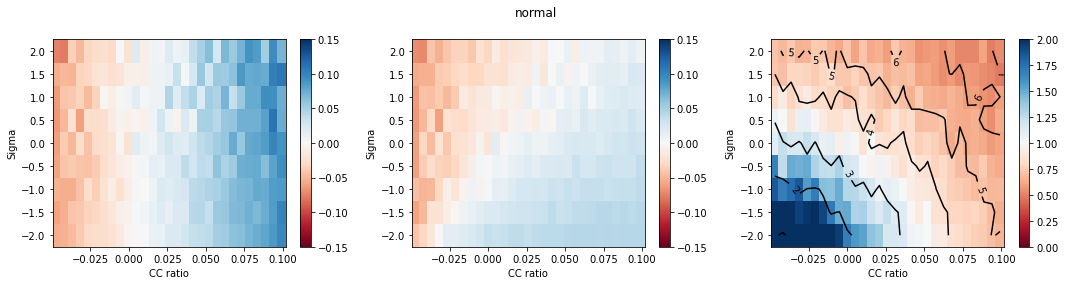

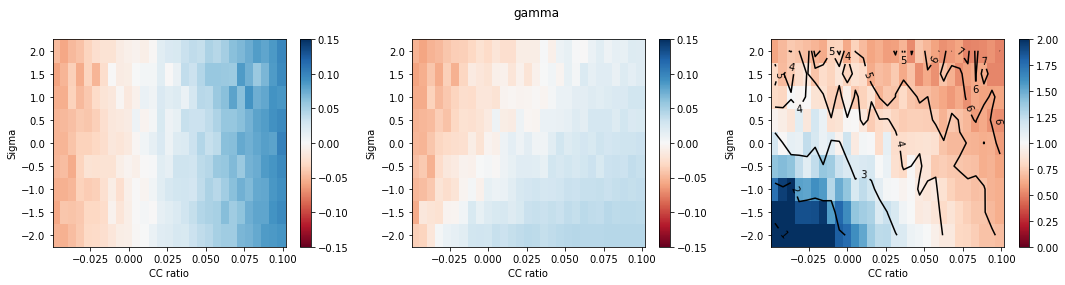

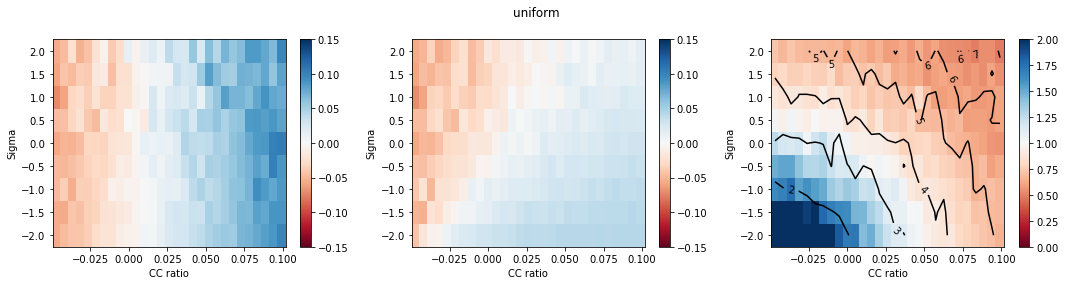

In [60]:
import utility_module_2_v_3 as uu
for dist in ['normal', 'gamma', 'uniform']:
    
    
    plt.figure(figsize = (15,4)  )
    R = means.shape[0]
    C = 3
    for itr_mu,mu in enumerate(means):
        
        
        xx,yy=np.meshgrid(uu.cen_to_box(ccss * (2*sigma)/sizeN - (2*sigma)/sizeN),uu.cen_to_box(sigmas-sigma_obs))
        xxc,yyc=np.meshgrid(ccss * (2*sigma)/sizeN - (2*sigma)/sizeN,sigmas-sigma_obs)

        plt.subplot(R,C, itr_mu * C + 1)
        plt.pcolor(xx,yy,data_model_ccs[dist][itr_mu,:,:]-data_obs_ccs[itr_mu,:,:],
                  vmin=-0.15,vmax=0.15,cmap='RdBu')

        
        plt.xlabel('CC ratio')
        plt.ylabel('Sigma')
        plt.colorbar()
        

        plt.subplot(R,C, itr_mu * C + 2)
        plt.xlabel('CC ratio')
        plt.ylabel('Sigma')        
        plt.pcolor(xx,yy,data_model_bc_ccs[dist][itr_mu,:,:]-data_obs_ccs[itr_mu,:,:],
                  vmin=-0.15,vmax=0.15,cmap='RdBu')
        plt.colorbar()
        
        plt.subplot(R,C, itr_mu * C + 3)
        plt.xlabel('CC ratio')
        plt.ylabel('Sigma')        
        pcc=plt.pcolor(xx,yy,data_model_bc_ccs[dist][itr_mu,:,:]/data_model_ccs[dist][itr_mu,:,:],
                  vmin=0,vmax=2,
                   cmap='RdBu')
        CS = plt.contour(xxc,yyc,data_model_sigmaccs[dist][itr_mu,:,:]-data_obs_ccs[itr_mu,:,:],np.arange(1,9.1,1),colors = 'black')
        plt.clabel(CS, CS.levels, inline=True, fontsize=10)
        

        plt.colorbar(pcc)
        
    plt.suptitle(dist)
    plt.tight_layout()
#     plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')

#     plt.colorbar()
#     plt.clim([0,lim[ind_name]])        
        
        

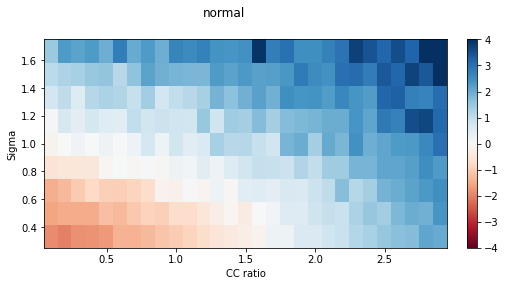

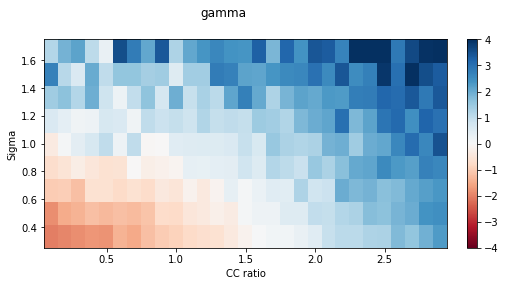

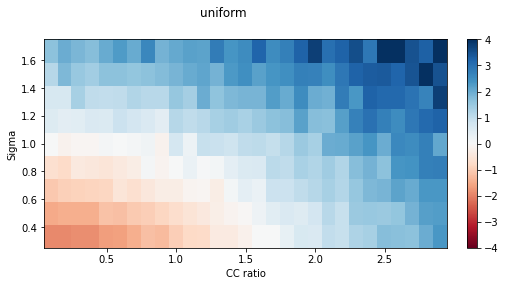

In [9]:
for dist in ['normal', 'gamma', 'uniform']:
    
    
    plt.figure(figsize = (8,4)  )
    R = means.shape[0]
    C = 2
    for itr_mu,mu in enumerate(means):
        
        
        xx,yy=np.meshgrid(ccss,sigmas/sigma_obs)

        # plt.subplot(R,C, itr_mu * C + 1)
        plt.pcolor(xx,yy,data_model_sigmaccs[dist][itr_mu,:,:]-3,
                  vmin=-4,vmax=4,
            cmap='RdBu')
        plt.xlabel('CC ratio')
        plt.ylabel('Sigma')
        plt.colorbar(fraction=0.025, pad=0.04)

        plt.gca().set_aspect(1)
        
    plt.suptitle(dist)
    plt.tight_layout()
#     plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')

#     plt.colorbar()
#     plt.clim([0,lim[ind_name]])        
        
        